In [ ]:
from torchvision.models import *
import torch
import sys

sys.path.append('../..')
from ic.train import utils
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import *

layer = 18

name = "resnet"

model = eval(f"{name}{layer}")(num_classes=3)
ckpt = torch.load(f'ckpt/{name}{layer}/model_best.pth.tar')
state_dict = ckpt['state_dict']

print(f"best acc is {ckpt['best_acc1']}")

for k in list(state_dict.keys()):
    if k.startswith('module'):
        # remove prefix
        state_dict[k[len("module.") :]] = state_dict[k]
    # delete renamed or unused keys
    del state_dict[k]

model.load_state_dict(state_dict)

test_set = ImageFolder(
    "/path/to/dataset/val",
    transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
)

model.cuda()

In [3]:
y_true, y_pred = utils.model_y_true_y_pred(model, test_loader, 'cuda', True)
accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='weighted')

  0%|          | 0/2 [00:00<?, ?it/s]

(0.7133333333333334, 0.703758115868499)

  0%|          | 0/2 [00:00<?, ?it/s]

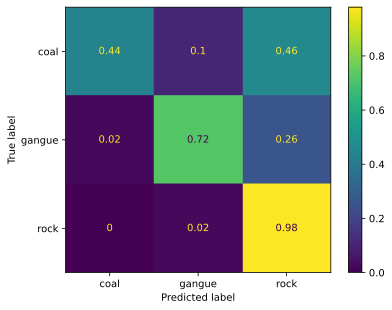

In [4]:
from d2l import torch as d2l


d2l.use_svg_display()
utils.display_confusion_matrix(model, test_loader, 'cuda', test_set.classes, 'true')

In [5]:
from ic.models import *
import numpy as np
from tqdm.autonotebook import tqdm

name1 = list(name.capitalize())
idx = name.index('net')
name1[idx] = name1[idx].upper()
m = eval(f"{''.join(name1)}FeatureExtractor")(layer, num_classes=3).cuda()
getattr(m, 'net').load_state_dict(state_dict)
m.cuda().eval()
with torch.no_grad():
    features = np.array([])
    labels = np.array([])
    pbar = tqdm(test_loader)
    for x, y in pbar:
        x = x.cuda()
        y = y.cuda()
        f = m(x)
        features = (
            np.concatenate([features, f.cpu().numpy()])
            if features.size
            else f.cpu().numpy()
        )
        labels = (
            np.concatenate([labels, y.cpu().numpy()])
            if labels.size
            else y.cpu().numpy()
        )
    pbar.close()

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import gc

model.cpu()
gc.collect()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 4/5] END kernel=1.41**2 * RBF(length_scale=0.5);, score=0.952 total time=   0.2s
[CV 2/5] END kernel=1.41**2 * RBF(length_scale=0.507);, score=0.707 total time=   0.2s
[CV 4/5] END kernel=1.41**2 * RBF(length_scale=0.507);, score=0.952 total time=   0.2s
[CV 3/5] END kernel=1.41**2 * RBF(length_scale=0.507);, score=0.759 total time=   0.2s
[CV 2/5] END kernel=1.41**2 * RBF(length_scale=0.5);, score=0.707 total time=   0.2s
[CV 1/5] END kernel=1.41**2 * RBF(length_scale=0.5);, score=0.811 total time=   0.2s
[CV 1/5] END kernel=1.41**2 * RBF(length_scale=0.507);, score=0.811 total time=   0.2s
[CV 3/5] END kernel=1.41**2 * RBF(length_scale=0.5);, score=0.759 total time=   0.2s
[CV 2/5] END kernel=1.41**2 * RBF(length_scale=0.514);, score=0.707 total time=   0.2s
[CV 1/5] END kernel=1.41**2 * RBF(length_scale=0.514);, score=0.811 total time=   0.2s
[CV 4/5] END kernel=1.41**2 * RBF(length_scale=0.514);, score=0.952 total 

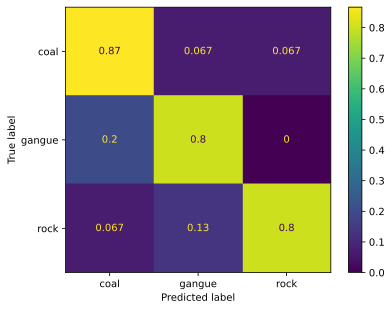

acc is 0.8222222222222222, f1 is 0.8232142857142857


In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=0, stratify=labels
)

param_grid = [
    {
        "kernel": [2 * RBF(l) for l in np.logspace(-1, 1, 100, base=2)]
        + [2 * RBF(l) for l in np.linspace(0.1, 1, 100)]
    }
]
gp = GaussianProcessClassifier(warm_start=True, multi_class='one_vs_one', n_jobs=-1)

clf = GridSearchCV(gp, param_grid, cv=5, n_jobs=-1, verbose=4, scoring='f1_weighted')
clf = make_pipeline(Normalizer(), MinMaxScaler(), clf)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, pred, display_labels=test_set.classes, normalize='true'
)
plt.show()
print(
    f"acc is {accuracy_score(y_test, pred)}, f1 is {f1_score(y_test, pred, average='weighted')}"
)

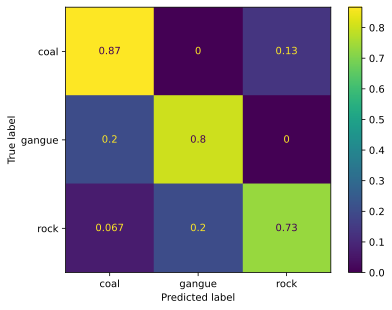

acc is 0.8, f1 is 0.7994047619047618


In [21]:
c_range = np.logspace(-5, 15, 11, base=2)
gamma_range = np.logspace(-9, 3, 13, base=2)
param_grid = {'C': c_range, 'gamma': gamma_range}
svc = GridSearchCV(SVC(), param_grid, n_jobs=12)
clf = make_pipeline(StandardScaler(), MinMaxScaler(), Normalizer(), SVC())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, pred, display_labels=test_set.classes, normalize='true'
)
plt.show()
print(
    f"acc is {accuracy_score(y_test, pred)}, f1 is {f1_score(y_test, pred, average='weighted')}"
)